# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for SBE-37 but the workflow is similar for all instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import EcoFOCIpy.io.sbe_parser as sbe_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

<div class="alert alert-block alert-warning">
<b>User Note:</b> Edit data between orange blocks for each instrument

In [92]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2019/Moorings/19ckp1a/'

In [93]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/sbe37/19ckp1a_sbe37_2357_40m.asc'
instrument = 'SBE-37 2357'
mooring_meta_file = user_data_dir+'logs/19CKP-1A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe37_cf.yaml'
inst_shortname = 's37'
###############################################################

#init and load data
sbe37_wop = sbe_parser.sbe37()
(sbe37_wop_data,sbe37_wop_header) = sbe37_wop.parse(filename=datafile,
                                                    return_header=True,
                                                    datetime_index=True) 

The data is output as a pandas dataframe from the intial module call and if its available, a header

<div class="alert alert-block alert-warning">

In [94]:
sbe37_wop_header

['* Sea-Bird SBE37 Data File:\n',
 '* FileName = C:\\Users\\foci\\Documents\\2020\\dyson_downloads\\19ckp1a_sbe37_2357_40m.asc\n',
 '* Software Version 1.59\n',
 '* Temperature SN = 2357\n',
 '* Conductivity SN = 2357\n',
 '* System UpLoad Time = Oct 09 2020 09:03:26\n',
 '** realtime: 170120\n',
 '** instime: 170314\n',
 '* ds\n',
 '* SBE37-SM V 2.6b  SERIAL NO. 2357    09 Oct 2020  17:03:44\n',
 '* not logging: received stop command\n',
 '* sample interval = 3600 seconds\n',
 '* samplenumber = 10386, free = 180264\n',
 '* do not transmit real-time data\n',
 '* output salinity with each sample\n',
 '* do not output sound velocity with each sample\n',
 '* store time with each sample\n',
 '* number of samples to average = 4\n',
 '* serial sync mode disabled\n',
 '* wait time after serial sync sampling = 30 seconds\n',
 '* internal pump not installed\n',
 '* temperature = 17.96 deg C\n',
 '\n',
 '\n',
 '* S>\n',
 '* SBE37-SM V 2.6b  2357\n',
 '* temperature:  28-apr-19\n',
 '*     TA0 = 

In [95]:
sbe37_wop_data

,temperature,conductivity,pressure,salinity
date_time,,,,
2019-08-04 00:00:20,11.3118,0.00006,-0.005,0.0059
2019-08-04 01:00:20,11.6743,0.00005,-0.023,0.0060
2019-08-04 02:00:20,12.6686,0.00005,-0.005,0.0066
2019-08-04 03:00:20,12.2965,0.00005,-0.023,0.0064
2019-08-04 04:00:20,11.6780,0.00005,-0.023,0.0060
...,...,...,...,...
2020-10-09 13:00:20,17.7940,0.00629,0.031,0.0381
2020-10-09 14:00:20,17.6727,0.00618,0.031,0.0376
2020-10-09 15:00:20,17.6382,0.00610,0.031,0.0372


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean()
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
    + I suggest if no change is needed... resample().mean() to the sample frequency just in case there is a small deviation from expected (<1min)
    

<div class="alert alert-block alert-danger">
<b>Time Clock Correction:</b> There are many ways to correct a clock error/drift or subsample/supersample.  Be sure you know why you've chosen the method you did.


In [96]:
sbe37_wop_data.index = sbe37_wop_data.index.round(freq='1H')
sbe37_wop_data

,temperature,conductivity,pressure,salinity
date_time,,,,
2019-08-04 00:00:00,11.3118,0.00006,-0.005,0.0059
2019-08-04 01:00:00,11.6743,0.00005,-0.023,0.0060
2019-08-04 02:00:00,12.6686,0.00005,-0.005,0.0066
2019-08-04 03:00:00,12.2965,0.00005,-0.023,0.0064
2019-08-04 04:00:00,11.6780,0.00005,-0.023,0.0060
...,...,...,...,...
2020-10-09 13:00:00,17.7940,0.00629,0.031,0.0381
2020-10-09 14:00:00,17.6727,0.00618,0.031,0.0376
2020-10-09 15:00:00,17.6382,0.00610,0.031,0.0372


<AxesSubplot:xlabel='date_time'>

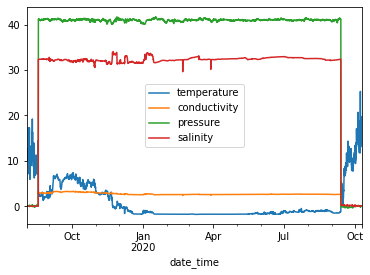

In [97]:
sbe37_wop_data.plot()

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [98]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [99]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [100]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
sbe37_wop_nc = ncCFsave.EcoFOCI_CFnc(df=sbe37_wop_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
sbe37_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [101]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
sbe37_wop_nc.expand_dimensions()

In [102]:
sbe37_wop_nc.variable_meta_data(variable_keys=list(sbe37_wop_data.columns.values),drop_missing=True)
sbe37_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
sbe37_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [103]:
#add global attributes
sbe37_wop_nc.deployment_meta_add()
sbe37_wop_nc.get_xdf()

#add instituitonal global attributes
sbe37_wop_nc.institution_meta_add()

#add instrument global attributes
sbe37_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
sbe37_wop_nc.provinance_meta_add()

#provide intial qc status field
sbe37_wop_nc.qc_status(qc_status='unknown')


## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [104]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)
depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.unqcd.nc'
sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.get_xdf(),
                           filename=filename,format="NETCDF3_CLASSIC")

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")



In [105]:
sbe37_wop_nc.autotrim_time()

<xarray.Dataset>
Dimensions:       (time: 9385, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-18T16:00:00 ... 2020-09-12T16...
  * latitude      (latitude) float64 70.84
  * longitude     (longitude) float64 -163.1
  * depth         (depth) float64 41.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 2.539 ... -1.182
    conductivity  (time, depth, latitude, longitude) float64 2.914 ... 2.616
    pressure      (time, depth, latitude, longitude) float64 41.17 ... 41.23
    salinity      (time, depth, latitude, longitude) float64 32.38 ... 32.42
Attributes: (12/15)
    Latitude_DegMMddW:                      70 50.329 N
    Longitude_DegMMddN:                     163 7.698 W
    MooringID:                              19CKP-1A
    platform_deployment_date:               2019-08-18T15:00:34Z
    platform_deployment_cruise_name:        OS1901
    platform_recovery_date:                 2020-09-12T16:52:00Z
    ...                                     ...
    InstrumentSerialNumber:                 2357
    InstrumentType:                         SBE-37
    date_created:                           2021-09-10T12:33:58Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [106]:
try:
    print(sbe37_wop_nc.autotrim_time().pressure.mean())
except:
    print(f'likely no pressure variable in datafile')

<xarray.DataArray 'pressure' ()>
array(41.02436399)


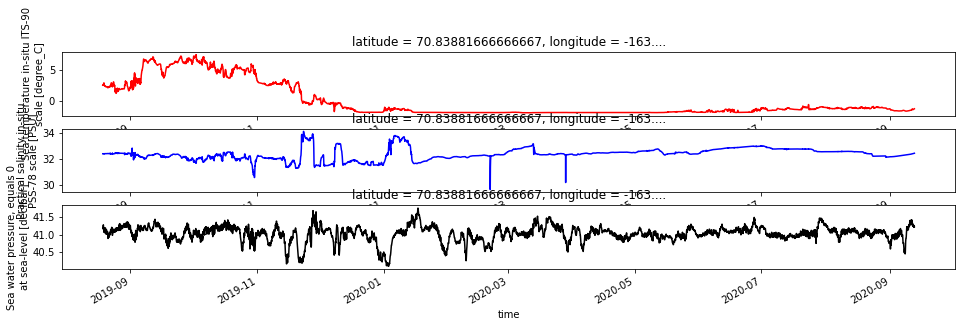

In [107]:
fig, ax = plt.subplots(3,figsize=(16, 4))
sbe37_wop_nc.autotrim_time().temperature.plot(ax=ax[0],color='r')
sbe37_wop_nc.autotrim_time().salinity.plot(ax=ax[1],color='b')
try:
    sbe37_wop_nc.autotrim_time().pressure.plot(ax=ax[2],color='k')
except:
    pass

In [108]:
#csvoutput if necessary - untrimmed for deck analysis
(sbe37_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','csv'))

<div class="alert alert-block alert-warning">
<b>User Alert:</b> Update deployment specific notes below.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

**correct depth 1m deeper for this instrument only**
- salinity fails in late-may?

In [112]:
import matplotlib.pyplot as plt
import pandas as pd
import EcoFOCIpy.io.erddap as erddap

url = "http://akutan.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [113]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='os1901l1',qclevel='final',concastno='030')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='preliminary',concastno='047')

some variable names switch between preliminary and final... this will eventually be resolved

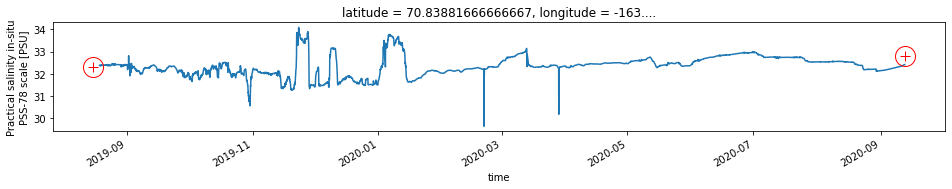

In [114]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe37_wop_nc.autotrim_time().salinity.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray

*TODO:* use erddap hosted data 

In [128]:
import xarray as xr
import datetime

In [118]:
# this task only needs to be run once and only if you are archiving deck data in the initial archive as csv
# (sbe37_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','csv')) #because the raw archived csv file doesn't trim out deck data, start with this file to edit 

***Steps to follow are stand alone and do not need the previous portionof the notebook to work... in future this may be shared as a seperate example***

In [132]:
# this reads the previous csv and assumes you've made modifications to the content but not the structure (record length or variable names)
sbe37_df_qc = pd.read_csv(user_data_dir+'working/'+filename.replace('nc','csv'), index_col=['time','depth','latitude','longitude']) #order is important

In [133]:
# this loads the initial working netcdf file
sbe37_wop_nc_qc = xr.load_dataset(user_data_dir+'working/'+filename)

In [134]:
sbe37_wop_nc_qc

<xarray.Dataset>
Dimensions:       (time: 9385, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-18T16:00:00 ... 2020-09-12T16...
  * latitude      (latitude) float64 70.84
  * longitude     (longitude) float64 -163.1
  * depth         (depth) float64 41.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 2.539 ... -1.182
    conductivity  (time, depth, latitude, longitude) float64 2.914 ... 2.616
    pressure      (time, depth, latitude, longitude) float64 41.17 ... 41.23
    salinity      (time, depth, latitude, longitude) float64 32.38 ... 32.42
Attributes: (12/15)
    Latitude_DegMMddW:                      70 50.329 N
    Longitude_DegMMddN:                     163 7.698 W
    MooringID:                              19CKP-1A
    platform_deployment_date:               2019-08-18T15:00:34Z
    platform_deployment_cruise_name:        OS1901
    platform_recovery_date:                 2020-09-12T16:52:00Z
    ...                                     ...
    InstrumentSerialNumber:                 2357
    InstrumentType:                         SBE-37
    date_created:                           2021-09-10T12:33:58Z
    date_modified:                          2021-09-10 12:55:15.791075
    QC_indicator:                           ProbablyGood
    history:                                Trimmed to deployment.\nQCd: 2021...

In [135]:
#replace original data with editied data
sbe37_wop_nc_qc['salinity'].values=xr.Dataset.from_dataframe(sbe37_df_qc)['salinity']

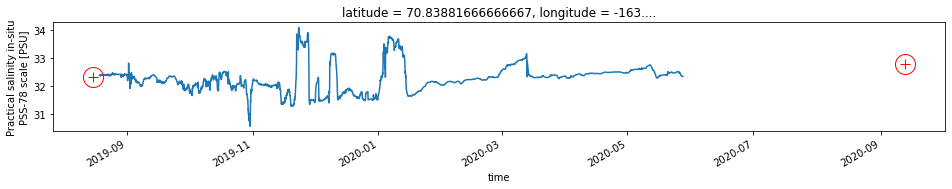

In [136]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe37_wop_nc_qc.salinity.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

### Update global attributes

In [137]:
sbe37_wop_nc_qc.attrs.update({'QC_indicator': 'ProbablyGood'})
sbe37_wop_nc_qc.attrs.update({'history':(sbe37_wop_nc_qc.history + "\nQCd: "+ str(datetime.datetime.today()))})

In [138]:
sbe37_wop_nc_qc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [139]:
sbe37_wop_nc_qc.to_netcdf(user_data_dir+'working/'+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})